# Stachurski Sargent Optimal Savings

This notebook replicates the code from the [Optimal Savings](http://lectures.quantecon.org/py/ifp.html) lecture, outlines a minor issue with the bounds of optimization, and suggests a minimal solution. 

The notebook progresses as follows:

1. Replicate code and figure from the [Optimal Savings](http://lectures.quantecon.org/py/ifp.html) lecture
2. Demonstrate a minor issue with code when b!=0
3. A simple solution?

# 1. Replicate code and figure from [Optimal Savings](http://lectures.quantecon.org/py/ifp.html)

The following code is directly copy-pasted from the [Optimal Savings](http://lectures.quantecon.org/py/ifp.html) lecture:

In [1]:
"""
Filename: ifp.py

Authors: Thomas Sargent, John Stachurski

Tools for solving the standard optimal savings / income fluctuation
problem for an infinitely lived consumer facing an exogenous income
process that evolves according to a Markov chain.

References
----------

http://quant-econ.net/py/ifp.html

"""
from textwrap import dedent
import numpy as np
from scipy.optimize import fminbound, brentq
from scipy import interp


class ConsumerProblem(object):
    """
    A class for solving the income fluctuation problem. Iteration with
    either the Coleman or Bellman operators from appropriate initial
    conditions leads to convergence to the optimal consumption policy.
    The income process is a finite state Markov chain.  Note that the
    Coleman operator is the preferred method, as it is almost always
    faster and more accurate. The Bellman operator is only provided for
    comparison.

    Parameters
    ----------
    r : scalar(float), optional(default=0.01)
        A strictly positive scalar giving the interest rate
    beta : scalar(float), optional(default=0.96)
        The discount factor, must satisfy (1 + r) * beta < 1
    Pi : array_like(float), optional(default=((0.60, 0.40),(0.05, 0.95))
        A 2D NumPy array giving the Markov matrix for {z_t}
    z_vals : array_like(float), optional(default=(0.5, 0.95))
        The state space of {z_t}
    b : scalar(float), optional(default=0)
        The borrowing constraint
    grid_max : scalar(float), optional(default=16)
        Max of the grid used to solve the problem
    grid_size : scalar(int), optional(default=50)
        Number of grid points to solve problem, a grid on [-b, grid_max]
    u : callable, optional(default=np.log)
        The utility function
    du : callable, optional(default=lambda x: 1/x)
        The derivative of u

    Attributes
    ----------
    r, beta, Pi, z_vals, b, u, du : see Parameters
    asset_grid : np.ndarray
        One dimensional grid for assets

    """

    def __init__(self, r=0.01, beta=0.96, Pi=((0.6, 0.4), (0.05, 0.95)),
                 z_vals=(0.5, 1.0), b=0, grid_max=16, grid_size=50,
                 u=np.log, du=lambda x: 1/x):
        self.u, self.du = u, du
        self.r, self.R = r, 1 + r
        self.beta, self.b = beta, b
        self.Pi, self.z_vals = np.array(Pi), tuple(z_vals)
        self.asset_grid = np.linspace(-b, grid_max, grid_size)

    def __repr__(self):
        m = "ConsumerProblem(r={r:g}, beta={be:g}, Pi='{n:g} by {n:g}', "
        m += "z_vals={z}, b={b:g}, grid_max={gm:g}, grid_size={gs:g}, "
        m += "u={u}, du={du})"
        return m.format(r=self.r, be=self.beta, n=self.Pi.shape[0],
                        z=self.z_vals, b=self.b,
                        gm=self.asset_grid.max(), gs=self.asset_grid.size,
                        u=self.u, du=self.du)

    def __str__(self):
        m = """
        Consumer Problem (optimal savings):
          - r (interest rate)                          : {r:g}
          - beta (discount rate)                       : {be:g}
          - Pi (transition matrix)                     : {n} by {n}
          - z_vals (state space of shocks)             : {z}
          - b (borrowing constraint)                   : {b:g}
          - grid_max (maximum of asset grid)           : {gm:g}
          - grid_size (number of points in asset grid) : {gs:g}
          - u (utility function)                       : {u}
          - du (marginal utility function)             : {du}
        """
        return dedent(m.format(r=self.r, be=self.beta, n=self.Pi.shape[0],
                               z=self.z_vals, b=self.b,
                               gm=self.asset_grid.max(),
                               gs=self.asset_grid.size, u=self.u,
                               du=self.du))

    def bellman_operator(self, V, return_policy=False):
        """
        The approximate Bellman operator, which computes and returns the
        updated value function TV (or the V-greedy policy c if
        return_policy is True).

        Parameters
        ----------
        V : array_like(float)
            A NumPy array of dim len(cp.asset_grid) times len(cp.z_vals)
        return_policy : bool, optional(default=False)
            Indicates whether to return the greed policy given V or the
            updated value function TV.  Default is TV.

        Returns
        -------
        array_like(float)
            Returns either the greed policy given V or the updated value
            function TV.

        """
        # === Simplify names, set up arrays === #
        R, Pi, beta, u, b = self.R, self.Pi, self.beta, self.u, self.b
        asset_grid, z_vals = self.asset_grid, self.z_vals
        new_V = np.empty(V.shape)
        new_c = np.empty(V.shape)
        z_idx = list(range(len(z_vals)))

        # === Linear interpolation of V along the asset grid === #
        vf = lambda a, i_z: interp(a, asset_grid, V[:, i_z])

        # === Solve r.h.s. of Bellman equation === #
        for i_a, a in enumerate(asset_grid):
            for i_z, z in enumerate(z_vals):
                def obj(c):  # objective function to be *minimized*
                    y = sum(vf(R * a + z - c, j) * Pi[i_z, j] for j in z_idx)
                    return - u(c) - beta * y
                c_star = fminbound(obj, np.min(z_vals), R * a + z + b)
                new_c[i_a, i_z], new_V[i_a, i_z] = c_star, -obj(c_star)

        if return_policy:
            return new_c
        else:
            return new_V

    def coleman_operator(self, c):
        """
        The approximate Coleman operator.

        Iteration with this operator corresponds to policy function
        iteration. Computes and returns the updated consumption policy
        c.  The array c is replaced with a function cf that implements
        univariate linear interpolation over the asset grid for each
        possible value of z.

        Parameters
        ----------
        c : array_like(float)
            A NumPy array of dim len(cp.asset_grid) times len(cp.z_vals)

        Returns
        -------
        array_like(float)
            The updated policy, where updating is by the Coleman
            operator. function TV.

        """
        # === simplify names, set up arrays === #
        R, Pi, beta, du, b = self.R, self.Pi, self.beta, self.du, self.b
        asset_grid, z_vals = self.asset_grid, self.z_vals
        z_size = len(z_vals)
        gamma = R * beta
        vals = np.empty(z_size)

        # === linear interpolation to get consumption function === #
        def cf(a):
            """
            The call cf(a) returns an array containing the values c(a,
            z) for each z in z_vals.  For each such z, the value c(a, z)
            is constructed by univariate linear approximation over asset
            space, based on the values in the array c
            """
            for i in range(z_size):
                vals[i] = interp(a, asset_grid, c[:, i])
            return vals

        # === solve for root to get Kc === #
        Kc = np.empty(c.shape)
        for i_a, a in enumerate(asset_grid):
            for i_z, z in enumerate(z_vals):
                def h(t):
                    expectation = np.dot(du(cf(R * a + z - t)), Pi[i_z, :])
                    return du(t) - max(gamma * expectation, du(R * a + z + b))
                Kc[i_a, i_z] = brentq(h, np.min(z_vals), R * a + z + b)

        return Kc

    def initialize(self):
        """
        Creates a suitable initial conditions V and c for value function
        and policy function iteration respectively.

        Returns
        -------
        V : array_like(float)
            Initial condition for value function iteration
        c : array_like(float)
            Initial condition for Coleman operator iteration

        """
        # === Simplify names, set up arrays === #
        R, beta, u, b = self.R, self.beta, self.u, self.b
        asset_grid, z_vals = self.asset_grid, self.z_vals
        shape = len(asset_grid), len(z_vals)
        V, c = np.empty(shape), np.empty(shape)

        # === Populate V and c === #
        for i_a, a in enumerate(asset_grid):
            for i_z, z in enumerate(z_vals):
                c_max = R * a + z + b
                c[i_a, i_z] = c_max
                V[i_a, i_z] = u(c_max) / (1 - beta)

        return V, c

## 1.1 Exercise 1 Text

The first exercise is to replicate the following figure, which compares PFI and VFI as solution methods

![Exercise 1 Replication](./vfi_vs_pfi.png)

The figure shows consumption policies computed by iteration of KK and TT respectively

- In the case of iteration with TT, the final value function is used to compute the observed policy

Consumption is shown as a function of assets with income zz held fixed at its smallest value

The following details are needed to replicate the figure

- (i) The parameters are the default parameters in the definition of consumerProblem
- (ii) The initial conditions are the default ones from initialize()
- (iii) Both operators are iterated 80 times

## 1.2 Replicate Figure Using $b=0$

In [2]:
# import libraries: 
import sys
import pylab as plt
from scipy.interpolate import InterpolatedUnivariateSpline

#-------------------------------------------------------------------------------
# (i.a) Set up all default parameters, explicitly: 
#-------------------------------------------------------------------------------

r = 0.01
beta = 0.96
b = 0.0

grid_max = 16
grid_size = 50

u = np.log
du = lambda x: 1/x

Pi = ((0.6, 0.4), (0.05, 0.95))
z_vals = (0.5, 1.0)

TT = 80 

# Create a grid for plotting that is much finer that the interpolation grid:
plotgrid = np.linspace(-(b*1.01), grid_max, grid_size*3)


For convenience, define a function that runs the T-length iteration:

In [3]:
def run_iteration(T, cons_prob, c_tm1, v_tm1):
    new_c = np.repeat(np.nan, T) # Fill out an empty one...
    for t in range(T):
        if t%10 == 0:
            print("t=",t)

        # Use try-except so can print both error messages 
        #
        # First execute coleman operator inside its own try-except:
        try:
            Kc = cons_prob.coleman_operator(c=c_tm1)
            c_tm1 = Kc  # ...yeah yeah not needed...
        except:
            if t < 5:
                print("NOTE: colman encountered this error:\n", sys.exc_info()[0])

        # Now execute bellman operator inside its own try-except;
        # this time also raise error encountered.
        try:
            new_V = cons_prob.bellman_operator(V=v_tm1, return_policy=False)
            new_c = cons_prob.bellman_operator(V=v_tm1, return_policy=True)
            v_tm1 = new_V

        except:
            if t < 5:
                print("NOTE: belman encountered this error:\n", sys.exc_info()[0])
                
    return c_tm1, new_c

Now run the default consumer problem:

In [4]:
#-------------------------------------------------------------------------------
# (i.b) Create a consumer problem with default values: 
#-------------------------------------------------------------------------------
consumer_prob = ConsumerProblem(r=r, beta=beta, Pi=Pi, z_vals=z_vals, b=b, 
                                grid_max=grid_max, grid_size=grid_size, u=u, 
                                du=du)

#-------------------------------------------------------------------------------
# (ii) Init values from consumer_prob.initialize():
#-------------------------------------------------------------------------------
v_tm1, c_tm1 = consumer_prob.initialize()

#-------------------------------------------------------------------------------
# (iii) Iterate both operators 80 times:
#-------------------------------------------------------------------------------
c_tm1, new_c = run_iteration(T=TT, cons_prob=consumer_prob, c_tm1=c_tm1, v_tm1=v_tm1)
    
# Define a function to create consumption functions:
def create_linear_interp_functions(prob, fxn_points):
    '''
    Given the output of either bellman_operator or coleman_operator, 
    return a tuple with a linear interpolation for each column. 
    '''
    rxn_interp = []
    for i in range(fxn_points.shape[1]):
        rxn_interp.append(InterpolatedUnivariateSpline( prob.asset_grid, fxn_points[:, i], k=1))
    return rxn_interp

# Create linear interpolations of each function:
c_pi = create_linear_interp_functions(consumer_prob, c_tm1)
c_vi = create_linear_interp_functions(consumer_prob, new_c)


('t=', 0)
('t=', 10)
('t=', 20)
('t=', 30)
('t=', 40)
('t=', 50)
('t=', 60)
('t=', 70)


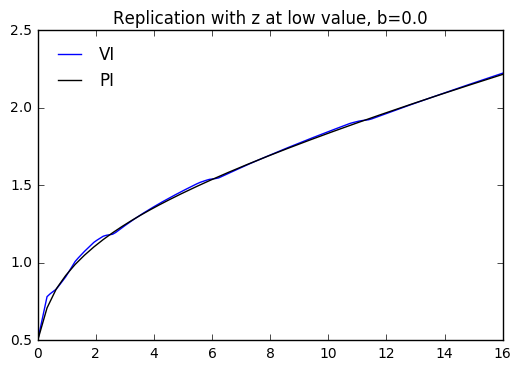

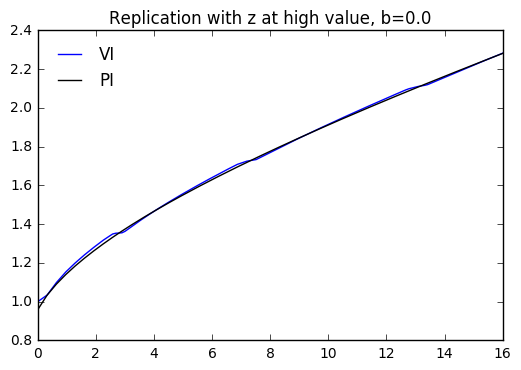

In [5]:
#-------------------------------------------------------------------------------
# (iv) Plot results with new colors:
#-------------------------------------------------------------------------------

plt.plot(plotgrid, c_vi[0](plotgrid), label="VI", color='blue')
plt.plot(plotgrid, c_pi[0](plotgrid), label="PI", color='black')
plt.title("Replication with z at low value, b="+str(b))
plt.legend(loc='best', frameon=False)
plt.show()


# For fun create this as well:
plt.plot(plotgrid, c_vi[1](plotgrid), label="VI", color='blue')
plt.plot(plotgrid, c_pi[1](plotgrid), label="PI", color='black')
plt.title("Replication with z at high value, b="+str(b))
plt.legend(loc='best', frameon=False)
plt.show()



# 2. Demonstrate a minor issue with code when b!=0
Now set b to a handful of values. We can try a few things to show the problem:

- b = 0.1
- b = 2.0
- b = -5.0  # just to show that it isn't that incorrectly. 

## 2.1 Demo:  $b=0.1$

Now try  $b=0.1$; this should result in an error. 

('t=', 0)
('NOTE: belman encountered this error:\n', <type 'exceptions.ValueError'>)
('NOTE: belman encountered this error:\n', <type 'exceptions.ValueError'>)
('NOTE: belman encountered this error:\n', <type 'exceptions.ValueError'>)
('NOTE: belman encountered this error:\n', <type 'exceptions.ValueError'>)
('NOTE: belman encountered this error:\n', <type 'exceptions.ValueError'>)
('t=', 10)
('t=', 20)
('t=', 30)
('t=', 40)
('t=', 50)
('t=', 60)
('t=', 70)
('NOTE: error:\n', <type 'exceptions.IndexError'>)
('****NOTE: error:\n', <type 'exceptions.NameError'>)


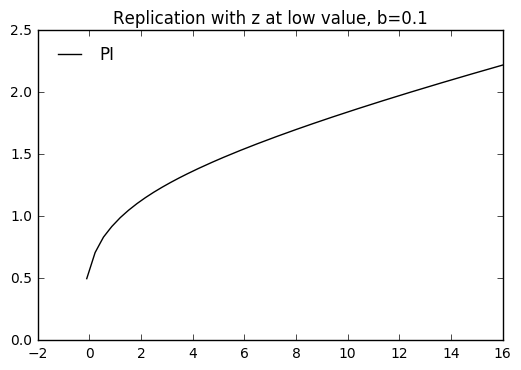

('****NOTE: error:\n', <type 'exceptions.NameError'>)


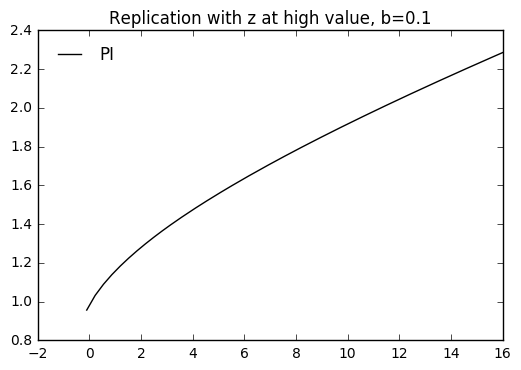

In [6]:
b = 0.1
consumer_prob_b01 = ConsumerProblem(r=r, beta=beta, Pi=Pi, z_vals=z_vals, b=b, 
                                grid_max=grid_max, grid_size=grid_size, u=u, 
                                du=du)
# Initialize
v_tm1, c_tm1 = consumer_prob_b01.initialize()

# Run iteration:
c_tm1, new_c = run_iteration(T=TT, cons_prob=consumer_prob_b01, c_tm1=c_tm1, v_tm1=v_tm1)

# Create linear interp:
c_pi_b01 = create_linear_interp_functions(consumer_prob_b01, c_tm1)
try:
    c_vi_b01 = create_linear_interp_functions(consumer_prob_b01, new_c)
except:
    #c_vi = [np.repeat(np.nan, len(c_pi[k])) for k in range(len(c_pi)) ]
    print("NOTE: error:\n", sys.exc_info()[0])

# Plot:
plotgrid = np.linspace(-(b*1.01), grid_max, grid_size*3)

plt.plot(plotgrid, c_pi_b01[0](plotgrid), label="PI", color='black')
try:
    plt.plot(plotgrid, c_vi_b01[0](plotgrid), label="VI", color='blue')
except:
    print("****NOTE: error:\n", sys.exc_info()[0])
plt.title("Replication with z at low value, b="+str(b))
plt.legend(loc='best', frameon=False)
plt.show()

# For fun create this as well:
plt.plot(plotgrid, c_pi_b01[1](plotgrid), label="PI", color='black')
    
try:
    plt.plot(plotgrid, c_vi_b01[1](plotgrid), label="VI", color='blue')
except:
    print("****NOTE: error:\n", sys.exc_info()[0])
    
plt.title("Replication with z at high value, b="+str(b))
plt.legend(loc='best', frameon=False)
plt.show()

## 2.2 Demo:  $b=2.0$

Now try  $b=2.0$; this should result in an error. 

('t=', 0)
('NOTE: belman encountered this error:\n', <type 'exceptions.ValueError'>)
('NOTE: belman encountered this error:\n', <type 'exceptions.ValueError'>)
('NOTE: belman encountered this error:\n', <type 'exceptions.ValueError'>)
('NOTE: belman encountered this error:\n', <type 'exceptions.ValueError'>)
('NOTE: belman encountered this error:\n', <type 'exceptions.ValueError'>)
('t=', 10)
('t=', 20)
('t=', 30)
('t=', 40)
('t=', 50)
('t=', 60)
('t=', 70)
('NOTE: error:\n', <type 'exceptions.IndexError'>)
('****NOTE: error:\n', <type 'exceptions.NameError'>)


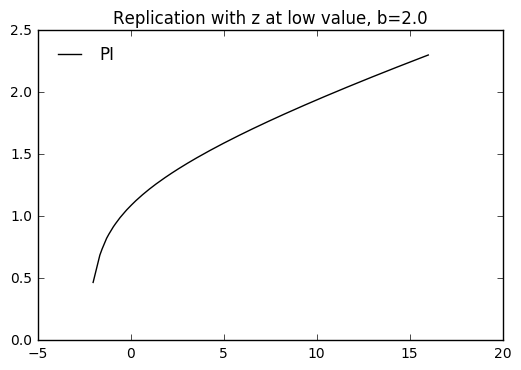

('****NOTE: error:\n', <type 'exceptions.NameError'>)


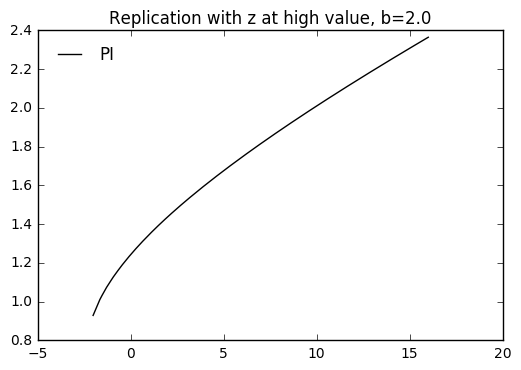

In [7]:
b = 2.0
consumer_prob_b2 = ConsumerProblem(r=r, beta=beta, Pi=Pi, z_vals=z_vals, b=b, 
                                grid_max=grid_max, grid_size=grid_size, u=u, 
                                du=du)
# Initialize
v_tm1, c_tm1 = consumer_prob_b2.initialize()

# Run iteration:
c_tm1, new_c = run_iteration(T=TT, cons_prob=consumer_prob_b2, c_tm1=c_tm1, v_tm1=v_tm1)

# Create linear interp:
c_pi_b2 = create_linear_interp_functions(consumer_prob_b2, c_tm1)
try:
    c_vi_b2 = create_linear_interp_functions(consumer_prob_b2, new_c)
except:
    #c_vi = [np.repeat(np.nan, len(c_pi[k])) for k in range(len(c_pi)) ]
    print("NOTE: error:\n", sys.exc_info()[0])

# Plot:
plotgrid = np.linspace(-(b*1.01), grid_max, grid_size*3)

plt.plot(plotgrid, c_pi_b2[0](plotgrid), label="PI", color='black')
try:
    plt.plot(plotgrid, c_vi_b2[0](plotgrid), label="VI", color='blue')
except:
    print("****NOTE: error:\n", sys.exc_info()[0])
plt.title("Replication with z at low value, b="+str(b))
plt.legend(loc='best', frameon=False)
plt.show()

# For fun create this as well:
plt.plot(plotgrid, c_pi_b2[1](plotgrid), label="PI", color='black')

try:
    plt.plot(plotgrid, c_vi_b2[1](plotgrid), label="VI", color='blue')
except:
    print("****NOTE: error:\n", sys.exc_info()[0])
    
plt.title("Replication with z at high value, b="+str(b))
plt.legend(loc='best', frameon=False)
plt.show()

## 2.3 Demo:  $b=-5.0$

Now try  $b=-5.0$; this doesn't throw an error but gives results that don't appear correct.

In [8]:
b = -5.0
consumer_prob_bminus5 = ConsumerProblem(r=r, beta=beta, Pi=Pi, z_vals=z_vals, b=b, 
                                grid_max=grid_max, grid_size=grid_size, u=u, 
                                du=du)
# Initialize
v_tm1, c_tm1 = consumer_prob_bminus5.initialize()

# Run iteration:
c_tm1, new_c = run_iteration(T=TT, cons_prob=consumer_prob_bminus5, c_tm1=c_tm1, v_tm1=v_tm1)

# Create linear interp:
c_pi_bm5 = create_linear_interp_functions(consumer_prob, c_tm1)
c_vi_bm5 = create_linear_interp_functions(consumer_prob, new_c)

('t=', 0)
('t=', 10)
('t=', 20)
('t=', 30)
('t=', 40)
('t=', 50)
('t=', 60)
('t=', 70)


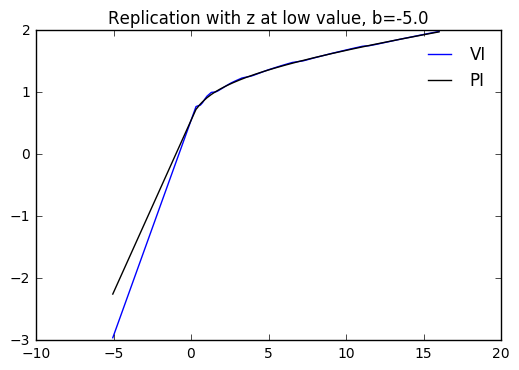

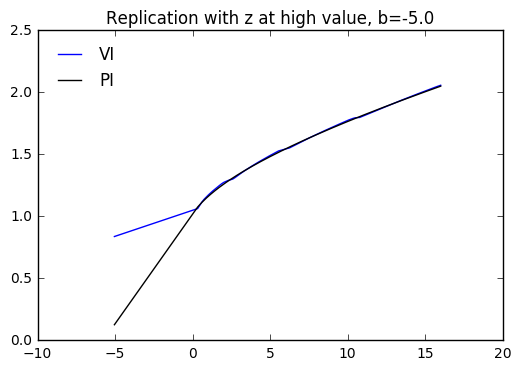

In [9]:
plotgrid = np.linspace((b*1.01), grid_max, grid_size*3)

plt.plot(plotgrid, c_vi_bm5[0](plotgrid), label="VI", color='blue')
plt.plot(plotgrid, c_pi_bm5[0](plotgrid), label="PI", color='black')
plt.title("Replication with z at low value, b="+str(b))
plt.legend(loc='best', frameon=False)
plt.show()


# For fun create this as well:
plt.plot(plotgrid, c_vi_bm5[1](plotgrid), label="VI", color='blue')
plt.plot(plotgrid, c_pi_bm5[1](plotgrid), label="PI", color='black')
plt.title("Replication with z at high value, b="+str(b))
plt.legend(loc='best', frameon=False)
plt.show()


# 3. A Simple Solution

There is a very simple solution: for each of the optimization/root-finding lines, search from a minimum of "machine zero" to the appropriate upper bound. (One could simply also use 0 as the lower bound, but I have occasionally hit errors doing this. Some optimizers like to try the lowest bound first; 0 of course doesn't play nicely with functions like log.)

Look for the comments 

    ## **** New code **** 
    
on the new code lines... tacky but easy to spot.


I also re-run the demos below to show better-looking solutions. 

## 3.1 Code Replicated with Simple Solution

In [10]:
"""
Filename: ifp.py

Authors: Thomas Sargent, John Stachurski

Tools for solving the standard optimal savings / income fluctuation
problem for an infinitely lived consumer facing an exogenous income
process that evolves according to a Markov chain.

References
----------

http://quant-econ.net/py/ifp.html

"""

class ConsumerProblem(object):
    """
    A class for solving the income fluctuation problem. Iteration with
    either the Coleman or Bellman operators from appropriate initial
    conditions leads to convergence to the optimal consumption policy.
    The income process is a finite state Markov chain.  Note that the
    Coleman operator is the preferred method, as it is almost always
    faster and more accurate. The Bellman operator is only provided for
    comparison.

    Parameters
    ----------
    r : scalar(float), optional(default=0.01)
        A strictly positive scalar giving the interest rate
    beta : scalar(float), optional(default=0.96)
        The discount factor, must satisfy (1 + r) * beta < 1
    Pi : array_like(float), optional(default=((0.60, 0.40),(0.05, 0.95))
        A 2D NumPy array giving the Markov matrix for {z_t}
    z_vals : array_like(float), optional(default=(0.5, 0.95))
        The state space of {z_t}
    b : scalar(float), optional(default=0)
        The borrowing constraint
    grid_max : scalar(float), optional(default=16)
        Max of the grid used to solve the problem
    grid_size : scalar(int), optional(default=50)
        Number of grid points to solve problem, a grid on [-b, grid_max]
    u : callable, optional(default=np.log)
        The utility function
    du : callable, optional(default=lambda x: 1/x)
        The derivative of u
    min_c : float                                                    ## **** New code **** 
        The minimum consumption value for use in the                 ## **** New code ****
        minimization and root-finding operations. Used for           ## **** New code ****
        numerical purposes.                                          ## **** New code **** 


    Attributes
    ----------
    r, beta, Pi, z_vals, b, u, du : see Parameters
    asset_grid : np.ndarray
        One dimensional grid for assets

    """

    def __init__(self, r=0.01, beta=0.96, Pi=((0.6, 0.4), (0.05, 0.95)),
                 z_vals=(0.5, 1.0), b=0, grid_max=16, grid_size=50,
                 u=np.log, du=lambda x: 1/x, min_c=1e-8):
        self.u, self.du = u, du
        self.r, self.R = r, 1 + r
        self.beta, self.b = beta, b
        self.Pi, self.z_vals = np.array(Pi), tuple(z_vals)
        self.asset_grid = np.linspace(-b, grid_max, grid_size)
        self.min_c = min_c                                         ## **** New code **** 

    def __repr__(self):
        m = "ConsumerProblem(r={r:g}, beta={be:g}, Pi='{n:g} by {n:g}', "
        m += "z_vals={z}, b={b:g}, grid_max={gm:g}, grid_size={gs:g}, "
        m += "u={u}, du={du})"
        return m.format(r=self.r, be=self.beta, n=self.Pi.shape[0],
                        z=self.z_vals, b=self.b,
                        gm=self.asset_grid.max(), gs=self.asset_grid.size,
                        u=self.u, du=self.du)

    def __str__(self):
        m = """
        Consumer Problem (optimal savings):
          - r (interest rate)                          : {r:g}
          - beta (discount rate)                       : {be:g}
          - Pi (transition matrix)                     : {n} by {n}
          - z_vals (state space of shocks)             : {z}
          - b (borrowing constraint)                   : {b:g}
          - grid_max (maximum of asset grid)           : {gm:g}
          - grid_size (number of points in asset grid) : {gs:g}
          - u (utility function)                       : {u}
          - du (marginal utility function)             : {du}
        """
        return dedent(m.format(r=self.r, be=self.beta, n=self.Pi.shape[0],
                               z=self.z_vals, b=self.b,
                               gm=self.asset_grid.max(),
                               gs=self.asset_grid.size, u=self.u,
                               du=self.du))

    def bellman_operator(self, V, return_policy=False):
        """
        The approximate Bellman operator, which computes and returns the
        updated value function TV (or the V-greedy policy c if
        return_policy is True).

        Parameters
        ----------
        V : array_like(float)
            A NumPy array of dim len(cp.asset_grid) times len(cp.z_vals)
        return_policy : bool, optional(default=False)
            Indicates whether to return the greed policy given V or the
            updated value function TV.  Default is TV.

        Returns
        -------
        array_like(float)
            Returns either the greed policy given V or the updated value
            function TV.

        """
        # === Simplify names, set up arrays === #
        R, Pi, beta, u, b = self.R, self.Pi, self.beta, self.u, self.b
        asset_grid, z_vals = self.asset_grid, self.z_vals
        new_V = np.empty(V.shape)
        new_c = np.empty(V.shape)
        z_idx = list(range(len(z_vals)))

        # === Linear interpolation of V along the asset grid === #
        vf = lambda a, i_z: interp(a, asset_grid, V[:, i_z])

        # === Solve r.h.s. of Bellman equation === #
        for i_a, a in enumerate(asset_grid):
            for i_z, z in enumerate(z_vals):
                def obj(c):  # objective function to be *minimized*
                    y = sum(vf(R * a + z - c, j) * Pi[i_z, j] for j in z_idx)
                    return - u(c) - beta * y
                #c_star = fminbound(obj, np.min(z_vals), R * a + z + b)
                c_star = fminbound(obj, self.min_c, R * a + z + b)              ## **** New code ****
                new_c[i_a, i_z], new_V[i_a, i_z] = c_star, -obj(c_star)

        if return_policy:
            return new_c
        else:
            return new_V

    def coleman_operator(self, c):
        """
        The approximate Coleman operator.

        Iteration with this operator corresponds to policy function
        iteration. Computes and returns the updated consumption policy
        c.  The array c is replaced with a function cf that implements
        univariate linear interpolation over the asset grid for each
        possible value of z.

        Parameters
        ----------
        c : array_like(float)
            A NumPy array of dim len(cp.asset_grid) times len(cp.z_vals)

        Returns
        -------
        array_like(float)
            The updated policy, where updating is by the Coleman
            operator. function TV.

        """
        # === simplify names, set up arrays === #
        R, Pi, beta, du, b = self.R, self.Pi, self.beta, self.du, self.b
        asset_grid, z_vals = self.asset_grid, self.z_vals
        z_size = len(z_vals)
        gamma = R * beta
        vals = np.empty(z_size)

        # === linear interpolation to get consumption function === #
        def cf(a):
            """
            The call cf(a) returns an array containing the values c(a,
            z) for each z in z_vals.  For each such z, the value c(a, z)
            is constructed by univariate linear approximation over asset
            space, based on the values in the array c
            """
            for i in range(z_size):
                vals[i] = interp(a, asset_grid, c[:, i])
            return vals

        # === solve for root to get Kc === #
        Kc = np.empty(c.shape)
        for i_a, a in enumerate(asset_grid):
            for i_z, z in enumerate(z_vals):
                def h(t):
                    expectation = np.dot(du(cf(R * a + z - t)), Pi[i_z, :])
                    return du(t) - max(gamma * expectation, du(R * a + z + b))
                #Kc[i_a, i_z] = brentq(h, np.min(z_vals), R * a + z + b)
                Kc[i_a, i_z] = brentq(h, self.min_c, R * a + z + b)                ## **** New code ****

        return Kc

    def initialize(self):
        """
        Creates a suitable initial conditions V and c for value function
        and policy function iteration respectively.

        Returns
        -------
        V : array_like(float)
            Initial condition for value function iteration
        c : array_like(float)
            Initial condition for Coleman operator iteration

        """
        # === Simplify names, set up arrays === #
        R, beta, u, b = self.R, self.beta, self.u, self.b
        asset_grid, z_vals = self.asset_grid, self.z_vals
        shape = len(asset_grid), len(z_vals)
        V, c = np.empty(shape), np.empty(shape)

        # === Populate V and c === #
        for i_a, a in enumerate(asset_grid):
            for i_z, z in enumerate(z_vals):
                c_max = R * a + z + b
                c[i_a, i_z] = c_max
                V[i_a, i_z] = u(c_max) / (1 - beta)

        return V, c

## 3.2 Re-Run Demos 

Now re-run the demos:

- b = 0.1
- b = 2.0
- b = -5.0  # just to show that it isn't that incorrectly. 

Here are all, one after another, in the following code block:

('t=', 0)
('t=', 10)
('t=', 20)
('t=', 30)
('t=', 40)
('t=', 50)
('t=', 60)
('t=', 70)


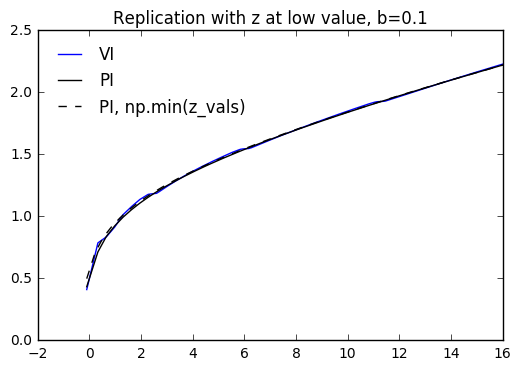

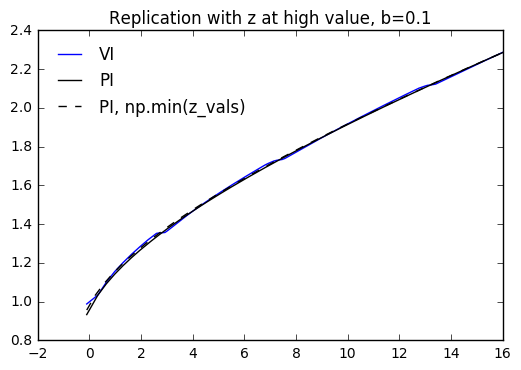

('t=', 0)
('t=', 10)
('t=', 20)
('t=', 30)
('t=', 40)
('t=', 50)
('t=', 60)
('t=', 70)


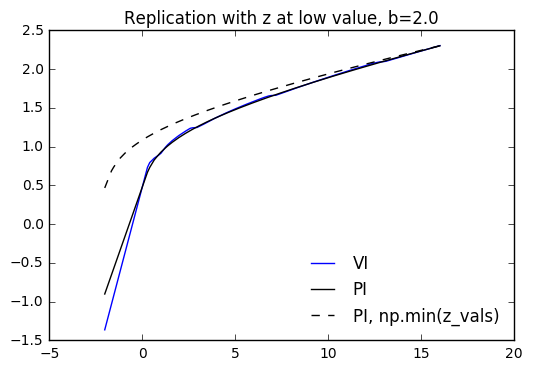

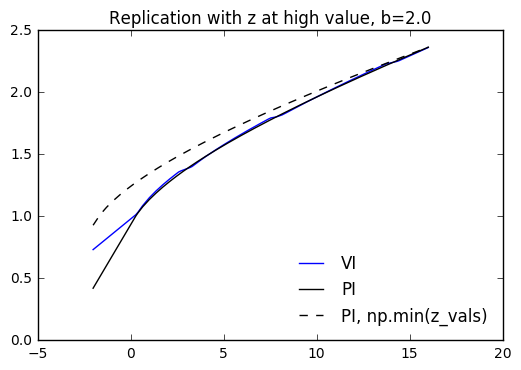

In [11]:
b = 0.1
consumer_prob_b01 = ConsumerProblem(r=r, beta=beta, Pi=Pi, z_vals=z_vals, b=b, 
                                grid_max=grid_max, grid_size=grid_size, u=u, 
                                du=du)
# Initialize
v_tm1, c_tm1 = consumer_prob_b01.initialize()

# Run iteration:
c_tm1, new_c = run_iteration(T=TT, cons_prob=consumer_prob_b01, c_tm1=c_tm1, v_tm1=v_tm1)

# Create linear interp:
c_pi = create_linear_interp_functions(consumer_prob, c_tm1)
c_vi = create_linear_interp_functions(consumer_prob, new_c)

# Plot:
plotgrid = np.linspace(-(b*1.01), grid_max, grid_size*3)

plt.plot(plotgrid, c_vi[0](plotgrid), label="VI", color='blue')
plt.plot(plotgrid, c_pi[0](plotgrid), label="PI", color='black')

plt.plot(plotgrid, c_pi_b01[0](plotgrid), label="PI, np.min(z_vals)", color='black', linestyle='--')

plt.title("Replication with z at low value, b="+str(b))
plt.legend(loc='best', frameon=False)
plt.show()

# For fun create this as well:
plt.plot(plotgrid, c_vi[1](plotgrid), label="VI", color='blue')
plt.plot(plotgrid, c_pi[1](plotgrid), label="PI", color='black')

plt.plot(plotgrid, c_pi_b01[1](plotgrid), label="PI, np.min(z_vals)", color='black', linestyle='--')

plt.title("Replication with z at high value, b="+str(b))
plt.legend(loc='best', frameon=False)
plt.show()


# ==============================================================================


b = 2.0
consumer_prob_b2 = ConsumerProblem(r=r, beta=beta, Pi=Pi, z_vals=z_vals, b=b, 
                                grid_max=grid_max, grid_size=grid_size, u=u, 
                                du=du)
# Initialize
v_tm1, c_tm1 = consumer_prob_b2.initialize()

# Run iteration:
c_tm1, new_c = run_iteration(T=TT, cons_prob=consumer_prob_b2, c_tm1=c_tm1, v_tm1=v_tm1)

# Create linear interp:
c_pi = create_linear_interp_functions(consumer_prob, c_tm1)
c_vi = create_linear_interp_functions(consumer_prob, new_c)

# Plot:
plotgrid = np.linspace(-(b*1.01), grid_max, grid_size*3)

plt.plot(plotgrid, c_vi[0](plotgrid), label="VI", color='blue')
plt.plot(plotgrid, c_pi[0](plotgrid), label="PI", color='black')

plt.plot(plotgrid, c_pi_b2[0](plotgrid), label="PI, np.min(z_vals)", color='black', linestyle='--')

plt.title("Replication with z at low value, b="+str(b))
plt.legend(loc='best', frameon=False)
plt.show()

# For fun create this as well:
plt.plot(plotgrid, c_vi[1](plotgrid), label="VI", color='blue')
plt.plot(plotgrid, c_pi[1](plotgrid), label="PI", color='black')

plt.plot(plotgrid, c_pi_b2[1](plotgrid), label="PI, np.min(z_vals)", color='black', linestyle='--')

plt.title("Replication with z at high value, b="+str(b))
plt.legend(loc='best', frameon=False)
plt.show()


## Finally Compare $b=5$ New to Previous $b=-5$

Now try $b=5$ instead of $b=-5$, and compare results to *previous code* solution with $b=-5$

('t=', 0)
('t=', 10)
('t=', 20)
('t=', 30)
('t=', 40)
('t=', 50)
('t=', 60)
('t=', 70)


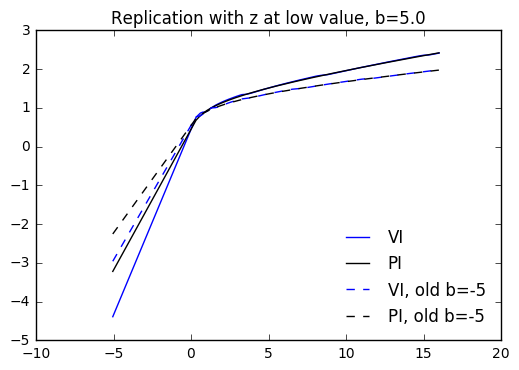

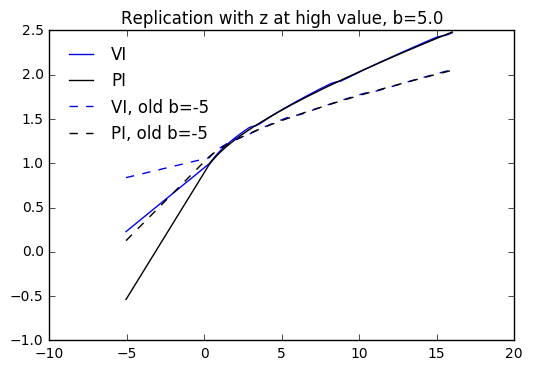

In [12]:
# ==============================================================================


b = 5.0
consumer_prob_b5 = ConsumerProblem(r=r, beta=beta, Pi=Pi, z_vals=z_vals, b=b, 
                                grid_max=grid_max, grid_size=grid_size, u=u, 
                                du=du)
# Initialize
v_tm1, c_tm1 = consumer_prob_b5.initialize()

# Run iteration:
c_tm1, new_c = run_iteration(T=TT, cons_prob=consumer_prob_b5, c_tm1=c_tm1, v_tm1=v_tm1)

# Create linear interp:
c_pi = create_linear_interp_functions(consumer_prob, c_tm1)
c_vi = create_linear_interp_functions(consumer_prob, new_c)

# Plot:
plotgrid = np.linspace(-(b*1.01), grid_max, grid_size*3)

plt.plot(plotgrid, c_vi[0](plotgrid), label="VI", color='blue')
plt.plot(plotgrid, c_pi[0](plotgrid), label="PI", color='black')

plt.plot(plotgrid, c_vi_bm5[0](plotgrid), label="VI, old b=-5", color='blue', linestyle="--")
plt.plot(plotgrid, c_pi_bm5[0](plotgrid), label="PI, old b=-5", color='black', linestyle="--")

plt.title("Replication with z at low value, b="+str(b))
plt.legend(loc='best', frameon=False)
plt.show()

# For fun create this as well:
plt.plot(plotgrid, c_vi[1](plotgrid), label="VI", color='blue')
plt.plot(plotgrid, c_pi[1](plotgrid), label="PI", color='black')

plt.plot(plotgrid, c_vi_bm5[1](plotgrid), label="VI, old b=-5", color='blue', linestyle="--")
plt.plot(plotgrid, c_pi_bm5[1](plotgrid), label="PI, old b=-5", color='black', linestyle="--")

plt.title("Replication with z at high value, b="+str(b))
plt.legend(loc='best', frameon=False)
plt.show()